In [1]:
!sudo apt-get install antiword
!pip install PyPDF2
!pip install Python-docx
from PyPDF2 import PdfReader
from docx import Document

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
antiword is already the newest version (0.37-16).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import warnings
import pickle
import joblib

In [3]:
import nltk

nltk.download('stopwords')

# Suppress warnings
warnings.filterwarnings('ignore')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
from google.colab import drive
drive.mount('/content/drive')

directories = {
    "/content/drive/MyDrive/classification/Peoplesoft":'PeopleSoft',
    "/content/drive/MyDrive/classification/SQL Developer Lightning insight":'SQL Developer',
    "/content/drive/MyDrive/classification/Workday":'Workday',
    "/content/drive/MyDrive/classification/Reactjs Developer":'React JS Developer'
}

# Initialize lists to store data
file_path_all = []
categories_all = []

# Function to extract text from files
def extract_text_from_file(file_path):
     try:
         if file_path.endswith('.pdf'):
             # Extract text from PDF
             reader = PdfReader(file_path)
             return " ".join(page.extract_text() for page in reader.pages if page.extract_text())
         elif file_path.endswith('.docx'):
             # Extract text from DOCX
             doc = Document(file_path)
             return " ".join(p.text for p in doc.paragraphs if p.text)
         elif file_path.endswith('.txt'):
             # Extract text from TXT
             with open(file_path, 'r', encoding='utf-8') as file:
                 return file.read()
         elif file_path.endswith('.doc'):
            # Extract text from DOC using antiword
            import subprocess
            result = subprocess.run(['antiword', file_path], capture_output=True, text=True)
            return result.stdout
         else:
             print(f"Unsupported file format or pywin32 not available: {file_path}")
             return ""
     except Exception as e:
         print(f"Error processing file {file_path}: {e}")
         return ""
# Process each directory
for directory, category in directories.items():
     if not os.path.exists(directory):
         print(f"Directory does not exist: {directory}")
         continue

     for file_name in os.listdir(directory):
         file_path = os.path.join(directory, file_name)
         if file_name.endswith(('.pdf', '.docx', '.txt', '.doc')):  # Process supported formats
             extracted_text = extract_text_from_file(file_path)
             if extracted_text:  # Only add non-empty text
                 file_path_all.append(extracted_text)
                 categories_all.append(category)

# Create a DataFrame with the results
data = pd.DataFrame({
     'Resumes': file_path_all,
     'Category': categories_all

 })

print("Dataframe Has Been Created Successfully.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataframe Has Been Created Successfully.


In [11]:
# Save the DataFrame to a CSV file
output_path = "resumes_dataset.csv"
data.to_csv(output_path, index=False, encoding='utf-8')
print(f"DataFrame saved successfully to {output_path}")

DataFrame saved successfully to resumes_dataset.csv


In [12]:
# Load the dataset
file_path='resumes_dataset.csv'
df = pd.read_csv(file_path)
print("Dataset Uploaded Successfully.")

Dataset Uploaded Successfully.


In [13]:
# Dataset Overview
print("Dataset Info:")
df.info()

print("\nFirst 5 Rows:")
print(df.head())

print("\nDataset Shape")
print(df.shape)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Resumes   79 non-null     object
 1   Category  79 non-null     object
dtypes: object(2)
memory usage: 1.4+ KB

First 5 Rows:
                                             Resumes    Category
0  \n\nR Ahmed\n      PeopleSoft Technical Consul...  PeopleSoft
1   PeopleSoft Admin VARKALA VIKAS Career Objecti...  PeopleSoft
2  Having 4.6 years of experience in PeopleSoft a...  PeopleSoft
3  \n                        PeopleSoft Admin/Peo...  PeopleSoft
4  C O N T A C T : Address: Manyata Tech Park, Na...  PeopleSoft

Dataset Shape
(79, 2)


Identify and Handling missing values and duplicate data

In [14]:
# Check for Missing or Null Values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Resumes     0
Category    0
dtype: int64


In [15]:
print('\nDuplicate Rows:')
print(df.duplicated().sum())

# Display duplicate rows
duplicate_rows = df[df.duplicated(subset=['Resumes', 'Category'], keep=False)]

print("Duplicate Rows:")
print(duplicate_rows)


Duplicate Rows:
2
Duplicate Rows:
                                              Resumes            Category
57  MAREEDU LOKESH BABU PROFESSIONAL OVERVIEW    A...  React JS Developer
58  Ui-Developer/ React JS Developer  NAME: KRISHN...  React JS Developer
63  Ui-Developer/ React JS Developer  NAME: KRISHN...  React JS Developer
77  MAREEDU LOKESH BABU PROFESSIONAL OVERVIEW    A...  React JS Developer


In [16]:
# Remove duplicate rows
df = df.drop_duplicates(subset=['Resumes', 'Category'], keep='first')

# Verify that duplicates are removed
print("Number of duplicates remaining:", df.duplicated(subset=['Resumes', 'Category']).sum())

Number of duplicates remaining: 0


Data Anomaly detection

In [17]:
# Display unique categories
print("Unique Categories:")
print(df['Category'].unique())

Unique Categories:
['PeopleSoft' 'SQL Developer' 'Workday' 'React JS Developer']


In [18]:
df['Category'].value_counts()

,count
Category,
React JS Developer,22
Workday,21
PeopleSoft,20
SQL Developer,14


In [19]:
# Identify resumes with excessive special characters
special_char_resumes = df[df['Resumes'].apply(lambda x: len(re.findall(r'[^a-zA-Z0-9\s]', x)) > 50)]

print("Resumes with excessive special characters:")
print(special_char_resumes)

# Count of resumes flagged as having excessive special characters
print(f"\nNumber of resumes with excessive special characters: {len(special_char_resumes)}")

Resumes with excessive special characters:
                                              Resumes            Category
0   \n\nR Ahmed\n      PeopleSoft Technical Consul...          PeopleSoft
1    PeopleSoft Admin VARKALA VIKAS Career Objecti...          PeopleSoft
2   Having 4.6 years of experience in PeopleSoft a...          PeopleSoft
3   \n                        PeopleSoft Admin/Peo...          PeopleSoft
4   C O N T A C T : Address: Manyata Tech Park, Na...          PeopleSoft
..                                                ...                 ...
73  Ranga Gaganam       Having 1+ years of success...  React JS Developer
74     \nPage | 1  \n Name: M. Prabakaran  \nTitle...  React JS Developer
75  MD KHIZARUDDIN RAUF   \t EXPERIENCE        ⇨ C...  React JS Developer
76  KAMBALA SAI SURENDRA      \tMandepeta \t      ...  React JS Developer
78  SHAIK ABDUL SHARUK    2 years’ Experience in W...  React JS Developer

[74 rows x 2 columns]

Number of resumes with excessive special char

Exploratory Data Analysis

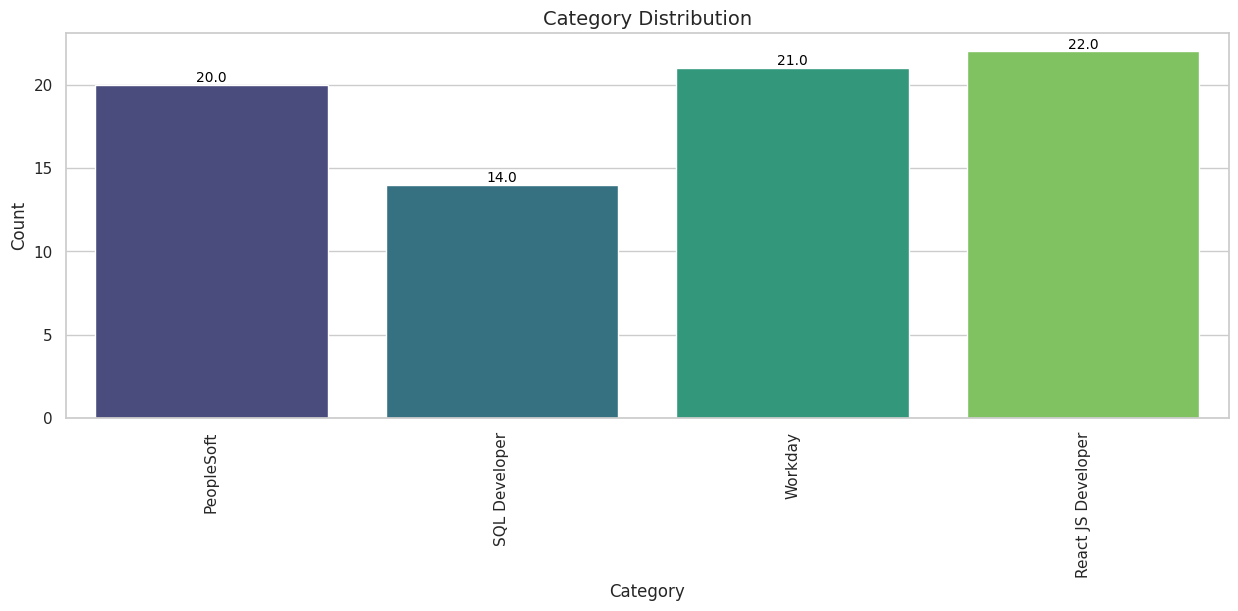

In [20]:
# Plot category distribution
plt.figure(figsize=(15, 5))
sns.set_theme(style="whitegrid")
ax = sns.countplot(x=df['Category'], palette="viridis")

# Add counts on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.xticks(rotation=90)
plt.title('Category Distribution', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

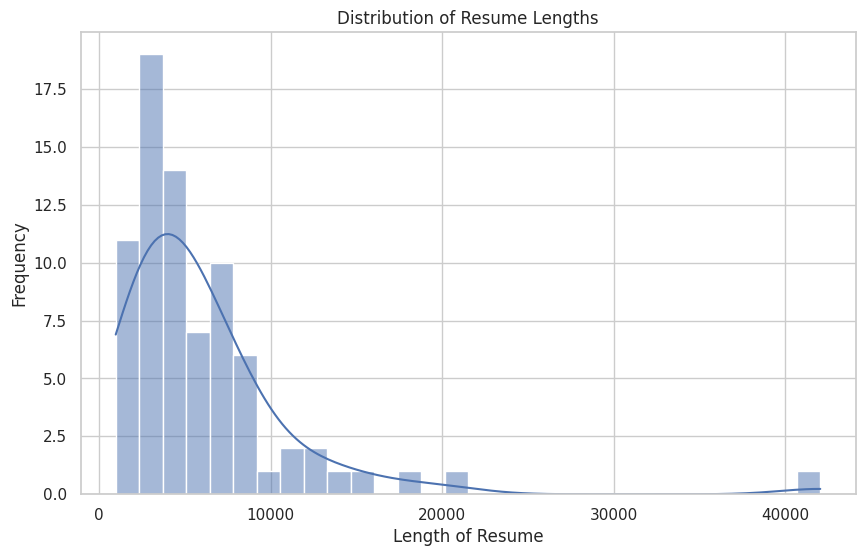

In [21]:
# Analyze the length of resumes
df['Resume_Length'] = df['Resumes'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['Resume_Length'], kde=True, bins=30)
plt.title('Distribution of Resume Lengths')
plt.xlabel('Length of Resume')
plt.ylabel('Frequency')
plt.show()

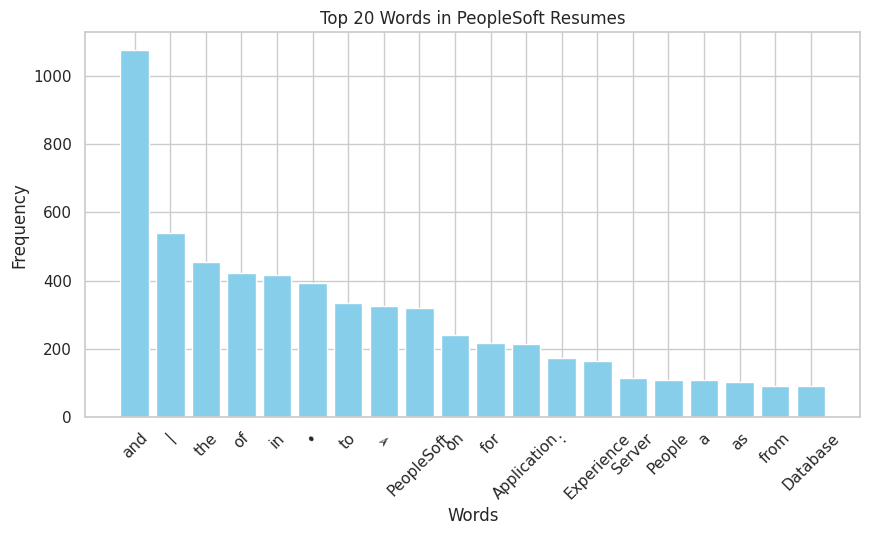

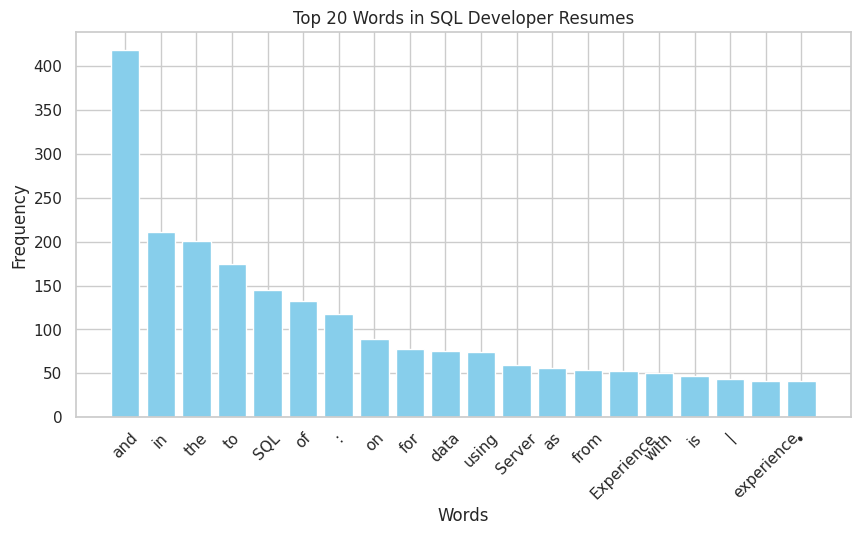

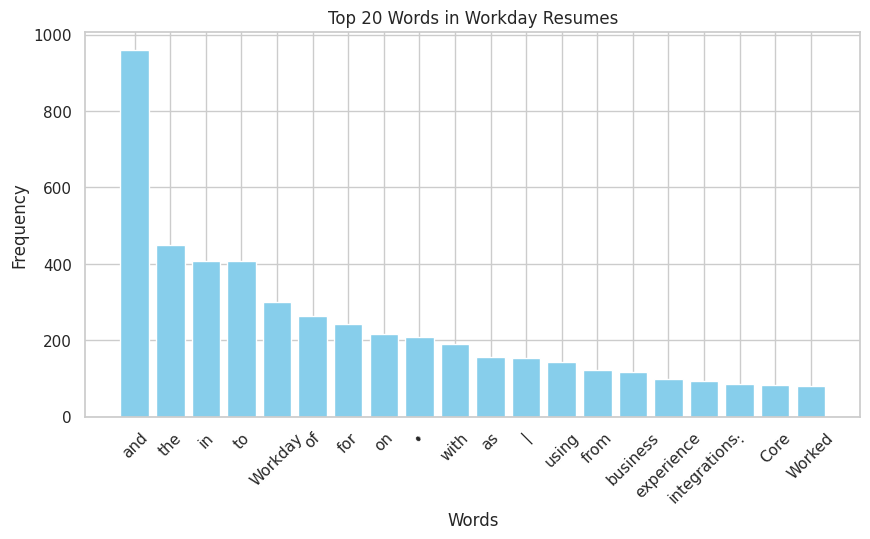

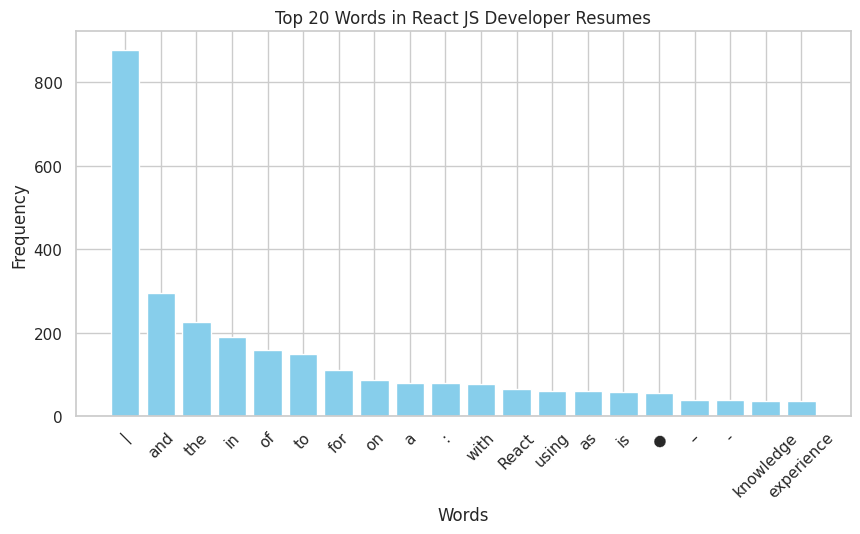

In [22]:
# Top N Words Across Categories

# Define the number of top words to display
N = 20

for category in df['Category'].unique():
    category_text = " ".join(df[df['Category'] == category]['Resumes'])
    word_freq = Counter(category_text.split())
    most_common_words = word_freq.most_common(N)

    # Plot the top N words for each category
    words, counts = zip(*most_common_words)
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts, color='skyblue')
    plt.title(f"Top {N} Words in {category} Resumes")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()

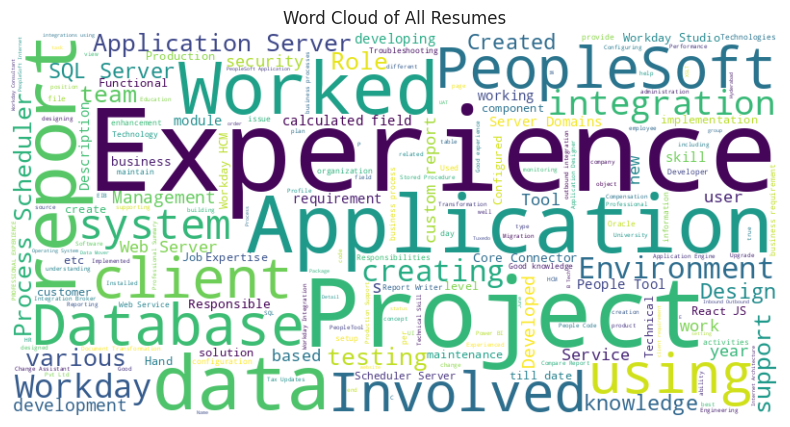

In [23]:
# Generate word cloud for all resumes
all_text = " ".join(df['Resumes'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Resumes")
plt.show()

Word Count Statistics:
count      77.000000
mean      724.363636
std       491.456480
min       133.000000
25%       389.000000
50%       578.000000
75%       934.000000
max      2692.000000
Name: Word_Count, dtype: float64


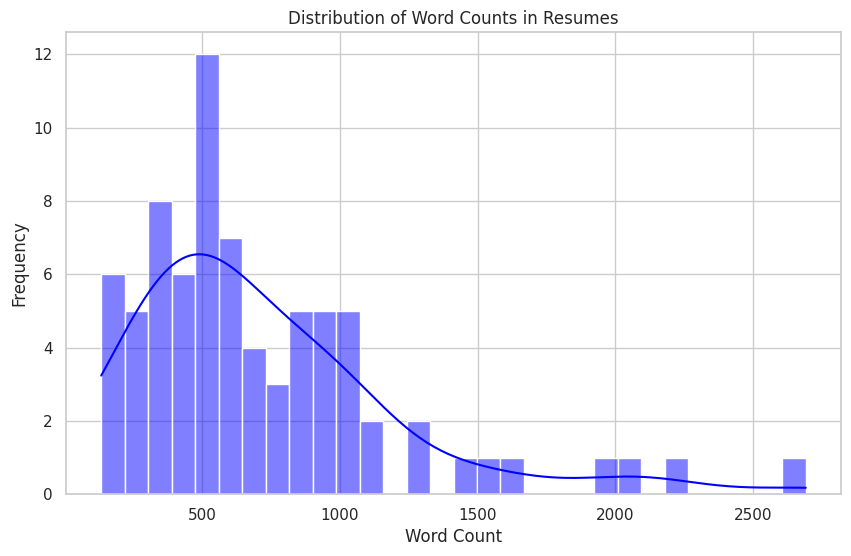

In [24]:
#  Word Count Analysis

# Calculate word count for each resume
df['Word_Count'] = df['Resumes'].apply(lambda x: len(x.split()))

# Display summary statistics for word count
print("Word Count Statistics:")
print(df['Word_Count'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df['Word_Count'], bins=30, kde=True, color='blue')
plt.title("Distribution of Word Counts in Resumes")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

Unique Word Count Statistics:
count     77.000000
mean     364.064935
std      154.387017
min       99.000000
25%      253.000000
50%      341.000000
75%      483.000000
max      809.000000
Name: Unique_Word_Count, dtype: float64


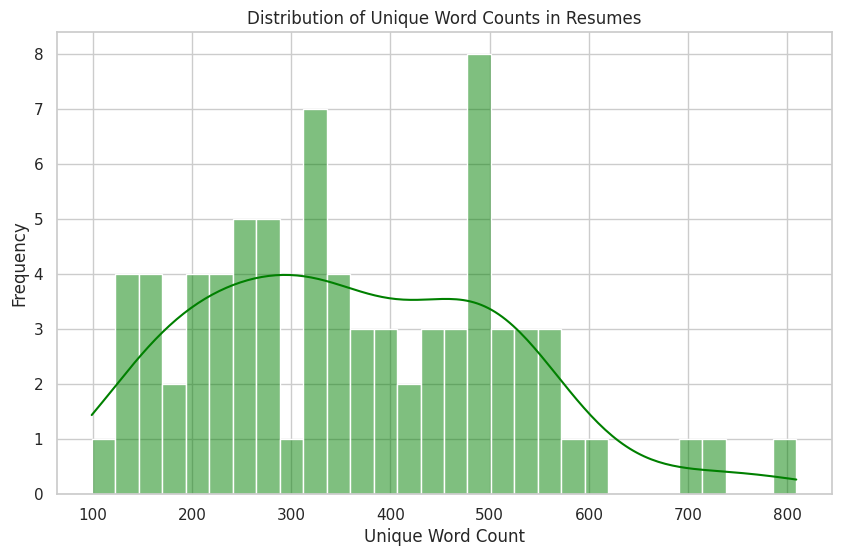

In [25]:
# Unique Word Count Analysis
# Calculate unique word count for each resume
df['Unique_Word_Count'] = df['Resumes'].apply(lambda x: len(set(x.split())))

# Display summary statistics for unique word count
print("Unique Word Count Statistics:")
print(df['Unique_Word_Count'].describe())

# Visualize unique word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Unique_Word_Count'], bins=30, kde=True, color='green')
plt.title("Distribution of Unique Word Counts in Resumes")
plt.xlabel("Unique Word Count")
plt.ylabel("Frequency")
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Stopword Ratio Statistics:
count    77.000000
mean      0.230082
std       0.037906
min       0.142857
25%       0.207668
50%       0.228700
75%       0.257115
max       0.321244
Name: Stopword_Ratio, dtype: float64


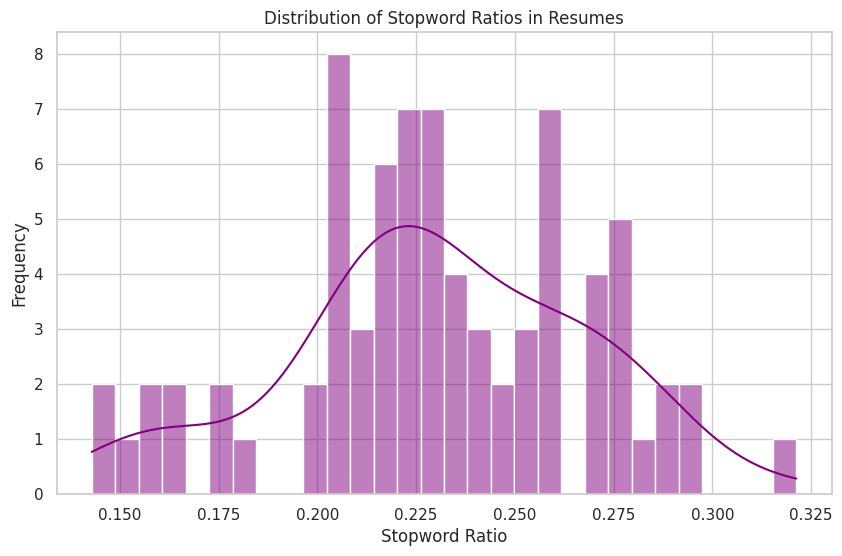

In [26]:
# Stopword Analysis

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Calculate stopword count
df['Stopword_Count'] = df['Resumes'].apply(
    lambda x: sum(1 for word in x.split() if word.lower() in stop_words)
)

# Calculate stopword ratio
df['Stopword_Ratio'] = df['Stopword_Count'] / df['Word_Count']

# Display summary statistics for stopword ratio
print("Stopword Ratio Statistics:")
print(df['Stopword_Ratio'].describe())

# Visualize stopword ratio distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Stopword_Ratio'], bins=30, kde=True, color='purple')
plt.title("Distribution of Stopword Ratios in Resumes")
plt.xlabel("Stopword Ratio")
plt.ylabel("Frequency")
plt.show()

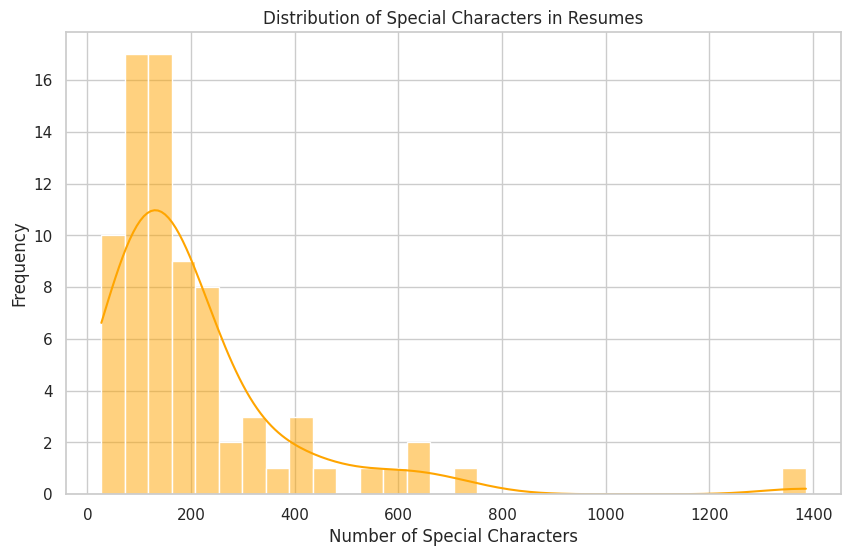

In [27]:
# Count special characters in each resume
df['Special_Char_Count'] = df['Resumes'].apply(lambda x: len(re.findall(r'[^a-zA-Z0-9\s]', x)))

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Special_Char_Count'], bins=30, kde=True, color='orange')
plt.title("Distribution of Special Characters in Resumes")
plt.xlabel("Number of Special Characters")
plt.ylabel("Frequency")
plt.show()

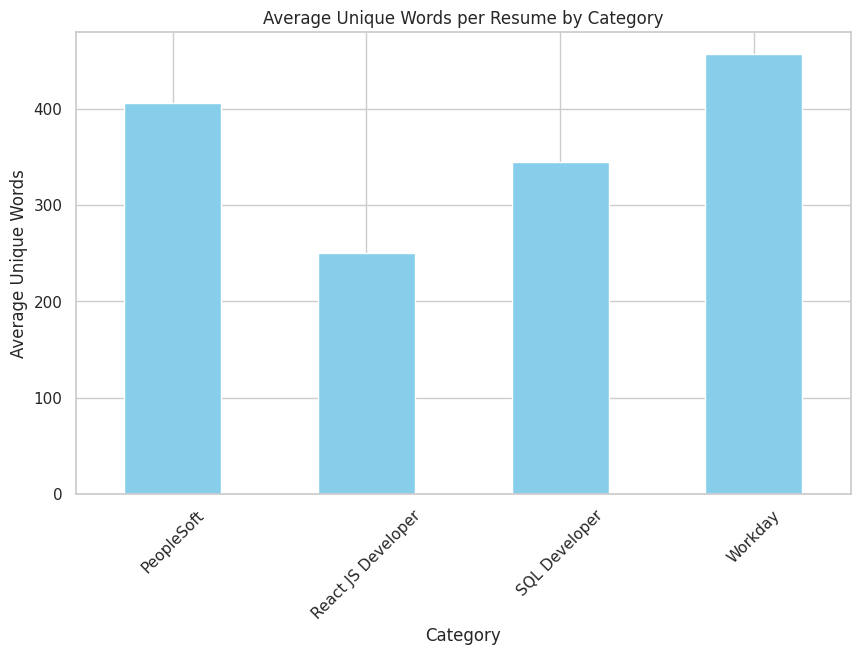

In [28]:
# Calculate the average unique word count per category
unique_word_avg = df.groupby('Category')['Unique_Word_Count'].mean()

# Plot the averages
unique_word_avg.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title("Average Unique Words per Resume by Category")
plt.xlabel("Category")
plt.ylabel("Average Unique Words")
plt.xticks(rotation=45)
plt.show()

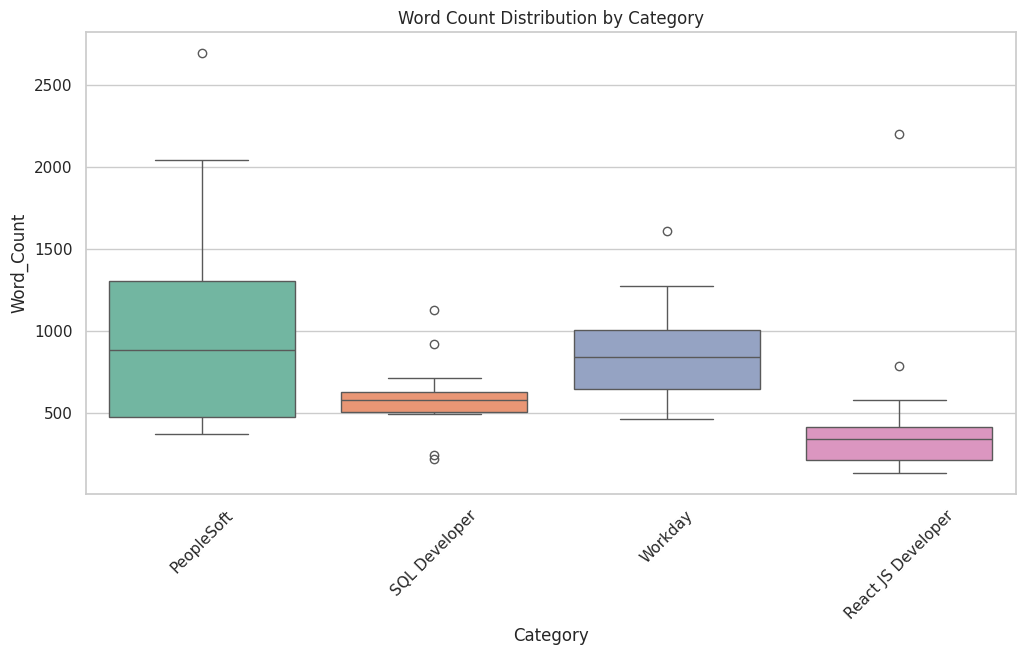

In [29]:
# Boxplot of word counts by category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Category', y='Word_Count', palette="Set2")
plt.title("Word Count Distribution by Category")
plt.xticks(rotation=45)
plt.show()

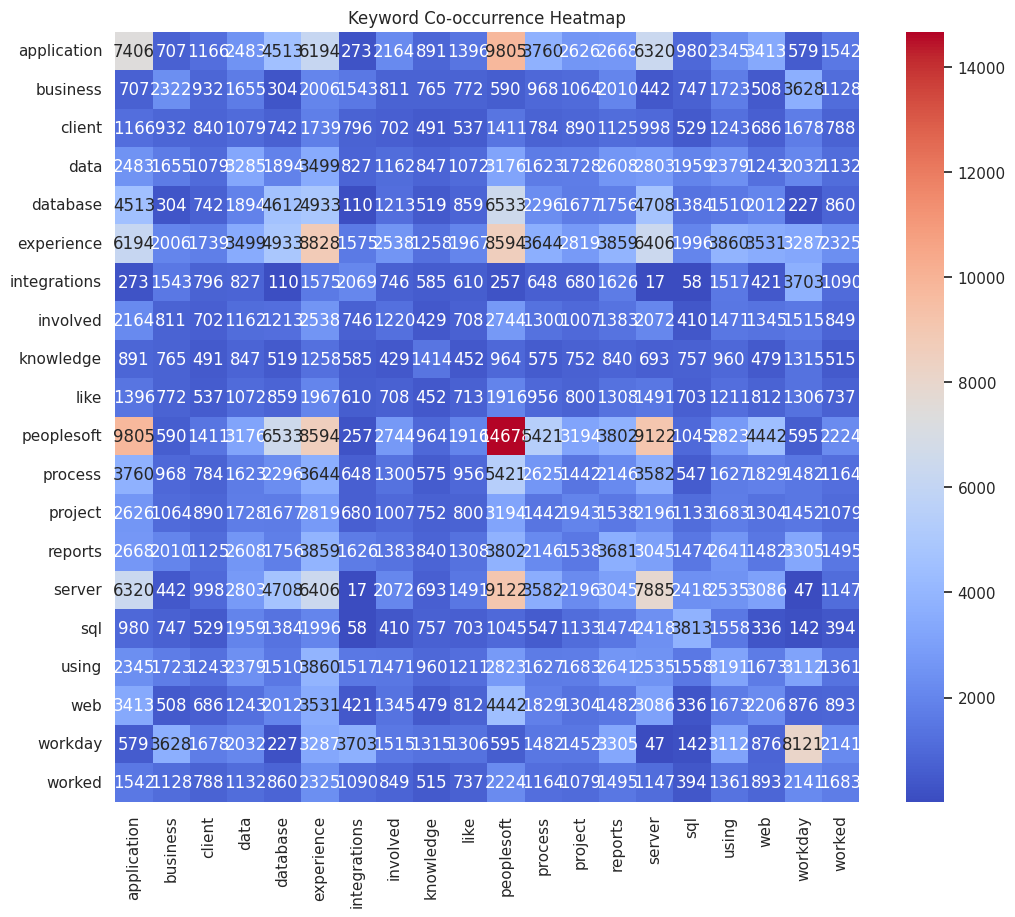

In [30]:
# Generate co-occurrence matrix for the dataset
vectorizer = CountVectorizer(max_features=20, stop_words='english')  # Limit to top 20 words
X = vectorizer.fit_transform(df['Resumes'])

# Convert to DataFrame for visualization
co_occurrence_matrix = (X.T * X).toarray()
words = vectorizer.get_feature_names_out()
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=words, columns=words)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_df, annot=True, fmt='d', cmap='coolwarm')
plt.title("Keyword Co-occurrence Heatmap")
plt.show()